<a href="https://colab.research.google.com/github/Jumarti96/Some-projects/blob/main/Colombia_monthly_CPI_time_series_analysis_and_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Colombia Monthly CPI Time Series Analysis and forecast***

## **1. Introduction and methodology**
The plan:
* Forecast Colombia's CPI using a SARIMAX model using ***unemployment rate***, ***Banco de la Republica's intermediation rate*** and ***trade balance***.
* Make simple forecasts forcast of ***unemployment rate*** and ***trade balance*** with SARIMA models.
* Create future values for ***Banco de la Republica's intermediation rate*** manually to simulate multiple scenarios.

## **2. Libraries**
* [geihdanepy](https://pypi.org/project/geihdanepy/) - faclitates accessing DANE (Departamento Administrativo Nacional de Estadística). DANE is the

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Time series libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import lagmat
import datetime as dt

# Data gathering libraries
#import geihdanepy as geih
from pandas_datareader import data as pdr

## **3. Data gathering and preparation**

I'm going to gather some economic data to test the function and develop a model to forecast Colombia's Inflation Rate. The data will be pulled from the [FRED (Federal Reserve Economic Data)](https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/) database, which offers easily accessible monthly data for many variables of interest related to many countries.

We will consider the effect of local factors as well as international factors:
* [Consumer Price Index](https://fred.stlouisfed.org/series/COLCPALTT01GPM) - Our target variable. Provided as monthly variation.
* [Unemployment Rate](https://fred.stlouisfed.org/series/COLLRUNTTTTSTSAM) - Phillips Curve theory suggest that normally we should expect an inverse relationship between inflation and the unemployment rate.
* [Interbank Rate](https://fred.stlouisfed.org/series/COLIRSTCI01STM) - Interest rate for short term lending between commercial banks in the country. It follows the intermediation rate set by Banco de la Republica very closely, which is managed mainly for inflation control. Typically, the intermediation rate is increased to make credit lending pricier, thus reducing consumption, which is expected to reduce inflation, and is decreased when inflation is lower than the inflation rate target of the Central Bank.
* [10-year Government Bond Yields](COLIRLTLT01STM) -
* [Exports value](COLXTEXVA01CXMLSAM) and [Imports value](https://fred.stlouisfed.org/series/COLXTIMVA01CXMLSAM) - The difference between Exports and Imports gives us the Net Exports, which will be our measure of the trade balance. There are multiple channels through which the trade balance can affect the inflation rate. For instance, persistent trade defficits can weaken a currency, thus making imports more expensive, and in the case of Colombia, many imported products are part of the goods measured in the CPI.



In [ ]:
start_date = '2000-01-01'                                                       # Initial start_date, which might change later depending on the data available
end_date = '2023-02-01'                                                         # End date of the dataset. This is optional, but I specify it to garantee reproducibility

vars = ['COLCPALTT01GPM',                                                       # CPI Index (monthly variation)
        'COLLRUNTTTTSTSAM',                                                     # Unemployment Rate
        'COLIRSTCI01STM',                                                       # Short-term interbank rate
        'COLIRLTLT01STM',                                                       # 10-year Government bond yields
        'COLXTEXVA01CXMLSAM',                                                   # Exports value
        'COLXTIMVA01CXMLSAM']                                                   # Imports value

dataset = pdr.DataReader(vars, data_source='fred',
                         start=start_date,
                         end=end_date)            # We specify the source 'fred' to refer to the FRED database

dataset.rename(columns={
    'COLCPALTT01GPM':'CPI_monthly',
    'COLLRUNTTTTSTSAM':'unemp_rate',
    'COLIRSTCI01STM':'int_rate',
    'COLIRLTLT01STM':'bond_yield',
    'COLXTEXVA01CXMLSAM':'exports',
    'COLXTIMVA01CXMLSAM':'imports'
}, inplace=True)
dataset

,CPI_monthly,unemp_rate,int_rate,bond_yield,exports,imports
DATE,,,,,,
2000-01-01,1.298246,NaN,7.48,NaN,1.129715e+09,9.551517e+08
2000-02-01,2.303429,NaN,9.57,NaN,1.128598e+09,9.290967e+08
2000-03-01,1.709836,NaN,10.05,NaN,1.021646e+09,1.015090e+09
2000-04-01,0.998668,NaN,10.22,NaN,9.325917e+08,9.424227e+08
2000-05-01,0.510877,NaN,10.56,NaN,1.063032e+09,9.858465e+08
...,...,...,...,...,...,...
2022-10-01,0.715056,10.878955,10.10,13.93,4.298353e+09,6.193842e+09
2022-11-01,0.772649,11.033210,10.99,13.23,4.675619e+09,5.705883e+09
2022-12-01,1.255432,11.395212,11.41,13.23,4.437616e+09,5.911721e+09


There's missing data in some months for some of the variables. For this exercise I will use only a range for which we have values for all variables, to make sure that we work with real data.

In [ ]:
dates_full_data = dataset[~dataset.isna().any(axis='columns')].index            # First we get the list of dates for which we have complete data

start_date = dates_full_data.min()                                              # We get the first date of the range
end_date = dates_full_data.max()                                                # We get the last date of the range

In [ ]:
dataset = dataset.loc[start_date:end_date]
dataset

,CPI_monthly,unemp_rate,int_rate,bond_yield,exports,imports
DATE,,,,,,
2007-01-01,0.762490,11.727439,7.55,9.450402,1.973488e+09,2.377161e+09
2007-02-01,1.174610,11.756647,7.78,9.830436,2.062178e+09,2.521107e+09
2007-03-01,1.216789,11.921866,7.96,9.878827,2.330630e+09,2.721171e+09
2007-04-01,0.893350,10.925087,8.05,10.014968,2.551542e+09,2.567100e+09
2007-05-01,0.306078,11.618654,8.49,9.839237,2.486048e+09,2.607269e+09
...,...,...,...,...,...,...
2022-10-01,0.715056,10.878955,10.10,13.930000,4.298353e+09,6.193842e+09
2022-11-01,0.772649,11.033210,10.99,13.230000,4.675619e+09,5.705883e+09
2022-12-01,1.255432,11.395212,11.41,13.230000,4.437616e+09,5.911721e+09


Let's check if there are dates within the daterange selected with NaN values. If there are we can input artificial but realistic values.

In [ ]:
dataset.isna().sum()

CPI_monthly    0
unemp_rate     0
int_rate       0
bond_yield     0
exports        0
imports        0
dtype: int64

Now we create the trade_balance field that will replace exports and imports.

In [ ]:
dataset['trade_balance_millions'] = (dataset['exports'] - dataset['imports'])/1000000
df = dataset.drop(columns = ['exports', 'imports']).copy()
df.head()

<ipython-input-6-310191ba3393>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['trade_balance_millions'] = (dataset['exports'] - dataset['imports'])/1000000


,CPI_monthly,unemp_rate,int_rate,bond_yield,trade_balance_millions
DATE,,,,,
2007-01-01,0.762490,11.727439,7.55,9.450402,-403.672449
2007-02-01,1.174610,11.756647,7.78,9.830436,-458.929744
2007-03-01,1.216789,11.921866,7.96,9.878827,-390.540448
2007-04-01,0.893350,10.925087,8.05,10.014968,-15.557302
2007-05-01,0.306078,11.618654,8.49,9.839237,-121.221655


## **4. Analysis of variables**

We proceed to analyse some properties of the CPI series and other variables, which will guide us in the process of building and accurate model.

These include properties typical of time series such as seasonality, stationarity, as well as measures of the relationship between the variables such as correlations.

### **4.1. Visualization of basic plots and historical correlation**

Some basic plots comparing the CPI with other variables on the same scale can give us some insight of the potential relationships between them.

To achieve this, first we need to normalize the data. This time I will normalize on a scale from 0 to 1.

In [ ]:
def normalize_df(df):
  """
  Function to take a dataframe and normalize each of the series into a scale of 0 to 1.
  """
  df_min, df_max = df.min(), df.max()                                             # We get the min and max value of each series in the dataframe.
  df_norm = (df - df_min) / (df_max - df_min)                                     # we calculate (actual_value - min_value)/(max_value - min_value)

  return df_norm

In [ ]:
df_norm = normalize_df(df)

# This results on the dataframe with all the values scaled between 0 and 1 for each variable
for col in df_norm.columns:
  print(col + '\n(min value: {0}, max value: {1}, mean value: {2:.2f}, std dev: {3:.2f})'.format(
      df_norm[col].min(),
      df_norm[col].max(),
      df_norm[col].mean(),
      df_norm[col].std()
      )
  )

CPI_monthly
(min value: 0.0, max value: 1.0, mean value: 0.36, std dev: 0.19)
unemp_rate
(min value: 0.0, max value: 1.0, mean value: 0.22, std dev: 0.18)
int_rate
(min value: 0.0, max value: 1.0, mean value: 0.32, std dev: 0.22)
bond_yield
(min value: 0.0, max value: 1.0, mean value: 0.35, std dev: 0.22)
trade_balance_millions
(min value: 0.0, max value: 1.0, mean value: 0.59, std dev: 0.22)


We proceed to make the plots  for CPI vs the other variables.

First, we create a function that allows us to plot the explanatory variables against the target variable, as well as the correlation between the series at different points in time.

In [ ]:
def plot_target_vs_exog(df, target_var, exog_vars, plot_corr=False, corr_window=12, normalize_df=False):
  """
  This function will plot the explanatory variables against the target variable.

  The user can set plot_corr=True to also plot the moving correlation of the two series,
    where each correlation value will be calculated with batches of records of the size set in corr_window

  For instance, if corr_window = 12 by default, the function will get batches of 12 records for both series
    and calculate the correlation between the series for those ranges that later will be plotted.
  """
  nplots = len(exog_vars)

  if plot_corr not in [True, False]:                                            # Check if the value set in plot_corr is valid (True or False)
    raise ValueError(f"'{plot_corr}' is not a valid value for the plot_corr argument. Valid values are True or False.")

  if normalize_df not in [True, False]:                                         # Check if the value set in plot_corr is valid (True or False)
    raise ValueError(f"'{normalize_df}' is not a valid value for the plot_corr argument. Valid values are True or False.")

  if normalize_df == True:
    df_min, df_max = df.min(), df.max()                                         # We get the min and max value of each series in the dataframe.
    df = (df - df_min) / (df_max - df_min)                                      # we calculate (actual_value - min_value)/(max_value - min_value)

  # If plot_corr == False, then only plot each explanatory variable against the target variable
  if plot_corr == False:
    fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=(9, 3*nplots))

    for i in range(nplots):                                                     # Make a plot for each explanatory variable
      axes[i].plot(df[target_var], color='blue', alpha=0.7, label=target_var)
      axes[i].plot(df[exog_vars[i]], color='orange', alpha=0.9, label=exog_vars[i])
      axes[i].set_title(f'{target_var} vs {exog_vars[i]}')
      axes[i].legend()

  # If plot_corr == True, then plot each explanatory variable against the target variable as well as the correlation of both variables in each valid point in the series
  if plot_corr == True:
    fig, axes = plt.subplots(nrows=nplots, ncols=2, figsize=(16, 3*nplots))

    correlations_index = df.index[corr_window:]

    for i in range(nplots):                                                     # Make a plot for each explanatory variable
      axes[i, 0].plot(df[target_var], color='blue', alpha=0.7, label=target_var)
      axes[i, 0].plot(df[exog_vars[i]], color='orange', alpha=0.9, label=exog_vars[i])
      axes[i, 0].set_title(f'{target_var} vs {exog_vars[i]}')
      axes[i, 0].legend()

      correlations = []                                                         # We create an empty list where the correlations for the evaluated variable will be stored
      for idx in np.arange(corr_window, len(df)):                               # For each batch of size=corr_window, capture the correlation
        y_series_values = df[target_var][idx-corr_window:idx]
        y_series_means = np.mean(y_series_values)
        x_series_values = df[exog_vars[i]][idx-corr_window:idx]
        x_series_means = np.mean(x_series_values)

        covar = np.sum((x_series_values - x_series_means) * (y_series_values - y_series_means))
        costd = np.sqrt(np.sum((x_series_values - x_series_means)**2) * np.sum((y_series_values - y_series_means)**2))
        correlations.append(covar/costd)                                        # https://www.analyticsvidhya.com/blog/2021/01/beginners-guide-to-pearsons-correlation-coefficient/
                                                                                # You can learn about the Pearson's Correlation calculation from the link above.
      # Plot reference lines to understand understand the strength of the correlation
      axes[i, 1].set_ylim([-1, 1])
      axes[i, 1].axhline(y=0, linestyle='-.', color='grey', alpha=0.2)
      axes[i, 1].axhline(y=.25, linestyle='-.', color='blue', alpha=0.1)
      axes[i, 1].axhline(y=-.25, linestyle='-.', color='blue', alpha=0.1)
      axes[i, 1].axhline(y=.5, linestyle='-.', color='blue', alpha=0.2)
      axes[i, 1].axhline(y=-.5, linestyle='-.', color='blue', alpha=0.2)
      axes[i, 1].axhline(y=.75, linestyle='-.', color='blue', alpha=0.3)
      axes[i, 1].axhline(y=-.75, linestyle='-.', color='blue', alpha=0.3)

      # Plot the moving correlation series
      axes[i, 1].plot(correlations_index, correlations, color='grey', alpha=0.9, label='historical correlation')
      axes[i, 1].set_title(f'{target_var} vs {exog_vars[i]} Historical Correlation')



  plt.tight_layout()
  plt.show()


I will use the function to evaluate the correlation between the variables for windows of 2 years (corr_window=24), as I think samples of this size could give us a fair idea of the behavior of the series.

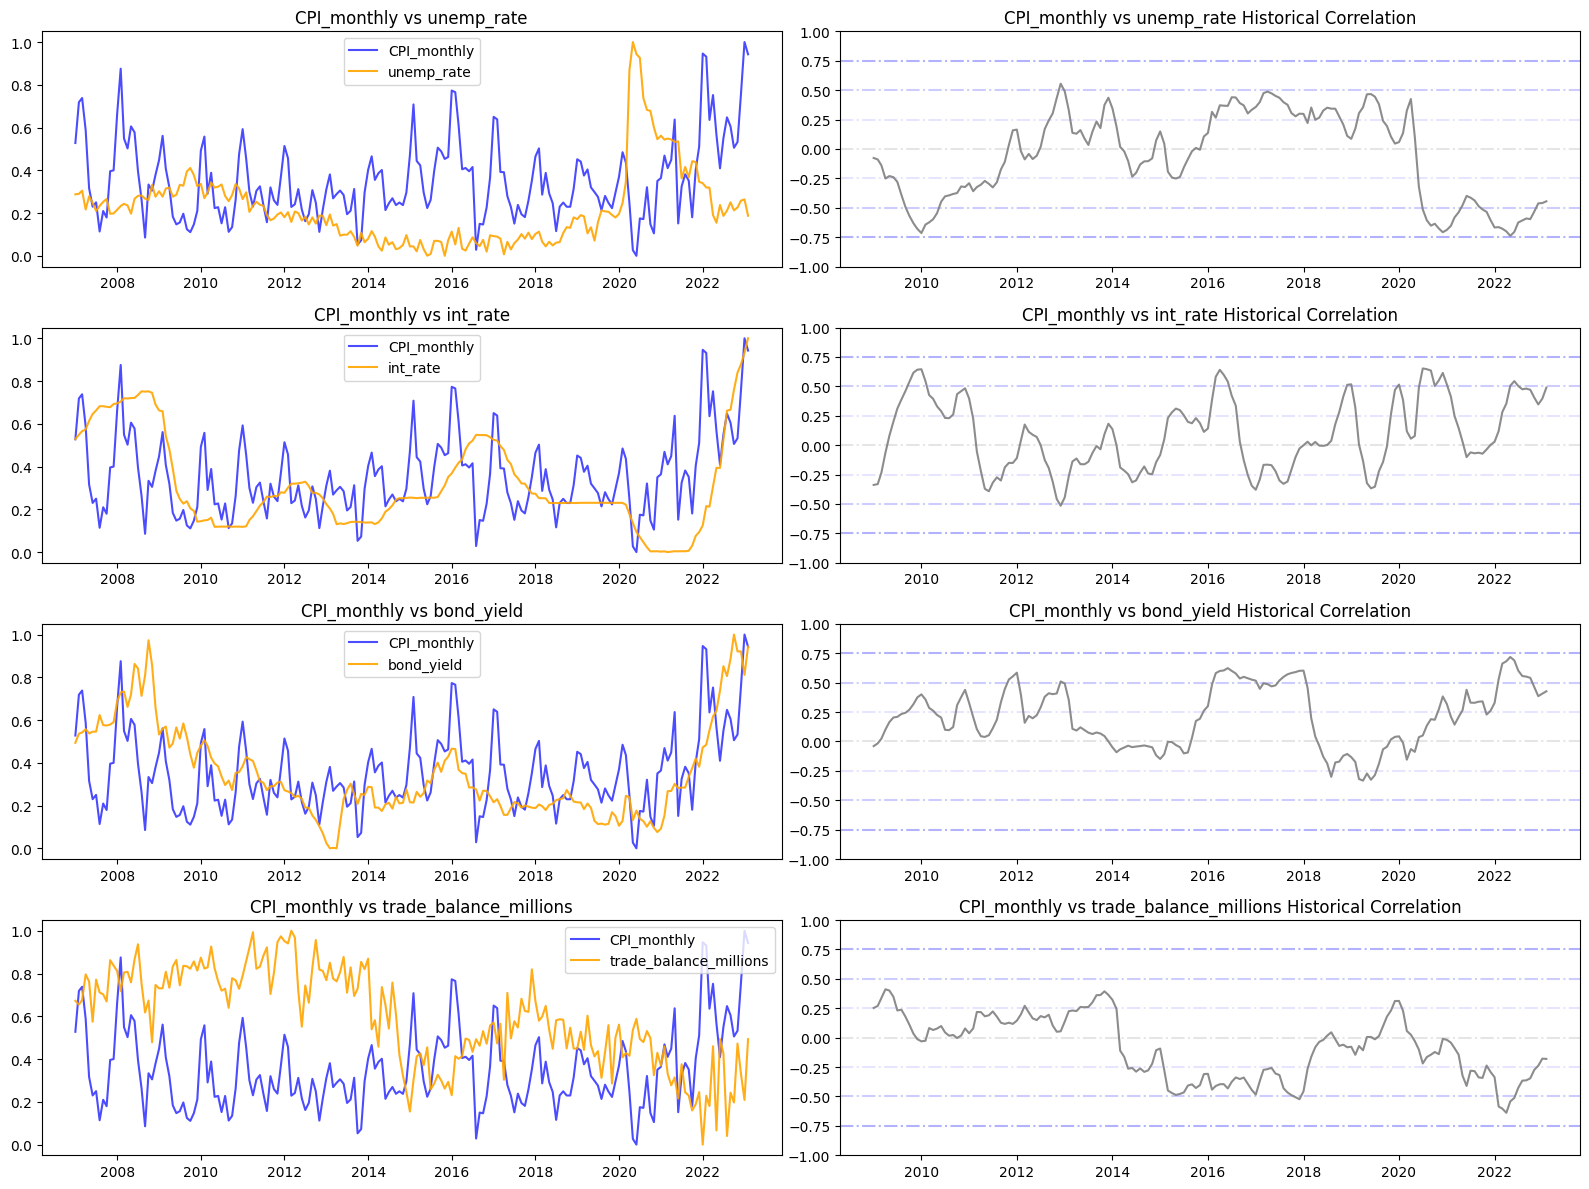

In [ ]:
target_var = 'CPI_monthly'
exog_vars = df_norm.columns.drop(target_var).values

plot_target_vs_exog(df_norm, target_var, exog_vars, plot_corr=True, corr_window=24)

Some clues from a very quick look:
* Almost none of the explanatory variables has a stable relationship with the CPI. In some periods the relationships are possitive, and in other they're negative.
* CPI vs Unemployment rate: in contrast to theory, the correlation between these two in many periods has been positive (up to 0.5 correlation). However, in the periods of strongest correlation (down to -0.75 correlation), they move in opposite directions, which also seem to be the periods where there were sort of crises (2009 global financial crisis, and 2020-2022 during and after covid).
* CPI vs interest rates:...
* CPI vs bond yields:...
* CPI vs trade balance:...

## **4.2 Analysis of stationarity**
To be able to make predictions of these series based on previous values, we the statistical methods we use require that the series have a relatively constant behavior across time. This is referred to as stationarity.

Constant behavior in a series can be defined as a constant mean, so no seasonality, and a constant variance across time. When a series has a trend or seasonality, the mean is not the same at different periods, and so the effect of previous values is not the same. Similarly, a variance that changes across time means that previous values have varying effects on future values.

For the statistical methods used in this project, we need to ensure that we use stationary series. Some common ways to transform a non-stationary series into a stationary one include differencing each value against its previous value or applying a logarithmic transformation to use every value in the series.

Before doing that, we need to find out whether our series are stationary or not. For this, the most common method is applying the Dickey-Fuller test on the data. Although it's hard to say with total confidence whether a series is stationary, this statistical test gives us an approximate answer. The test evaluate the following hypothesis:
* Null hypothesis: the series is non-stationary.
* Alternative hypothesis: the series is stationary.

Considering a 5% confidence threshold, if we can say with over 5% confidence that the series is non-stationary, then we assume it is. However if the confidence value is less than 5%, we will assume is is stationary and proceed to forecast with it without need of transformation.

In [ ]:
for col in df.columns:
  dickey_fuller_result = adfuller(df[col])
  print('Dickey-Fuller test p-value on {0}: {1:.4f}\n'.format(col, dickey_fuller_result[1]))

Dickey-Fuller test p-value on CPI_monthly: 0.8184

Dickey-Fuller test p-value on unemp_rate: 0.2180

Dickey-Fuller test p-value on int_rate: 0.0657

Dickey-Fuller test p-value on bond_yield: 0.6528

Dickey-Fuller test p-value on trade_balance_millions: 0.7505



According to the tests above, for none of the series we can reject the the assumption that the series are non-stationary. Therefore, we will need to create a new version of the dataset with all the series transformed.

The method we will employ is differencing the series. The new series that result from this transformation can be interpreted as series of the variations from each period to the next.

In [ ]:
df_sta = df.diff().copy().iloc[1:]                                              # Function to get the difference of each value vs its previous value. The first value will be nan since it has no previous value to substract from it.

for col in df_sta.columns:
  dickey_fuller_result = adfuller(df_sta[col])
  print('Dickey-Fuller test p-value on {0}: {1:.4f}\n'.format(col, dickey_fuller_result[1]))

Dickey-Fuller test p-value on CPI_monthly: 0.0000

Dickey-Fuller test p-value on unemp_rate: 0.0000

Dickey-Fuller test p-value on int_rate: 0.0369

Dickey-Fuller test p-value on bond_yield: 0.0000

Dickey-Fuller test p-value on trade_balance_millions: 0.0000



According to the Dickey-Fuller test, now we con confidently reject the assumption that the series aren't non-stationary.

It's worth evaluating again the correlations across periods.

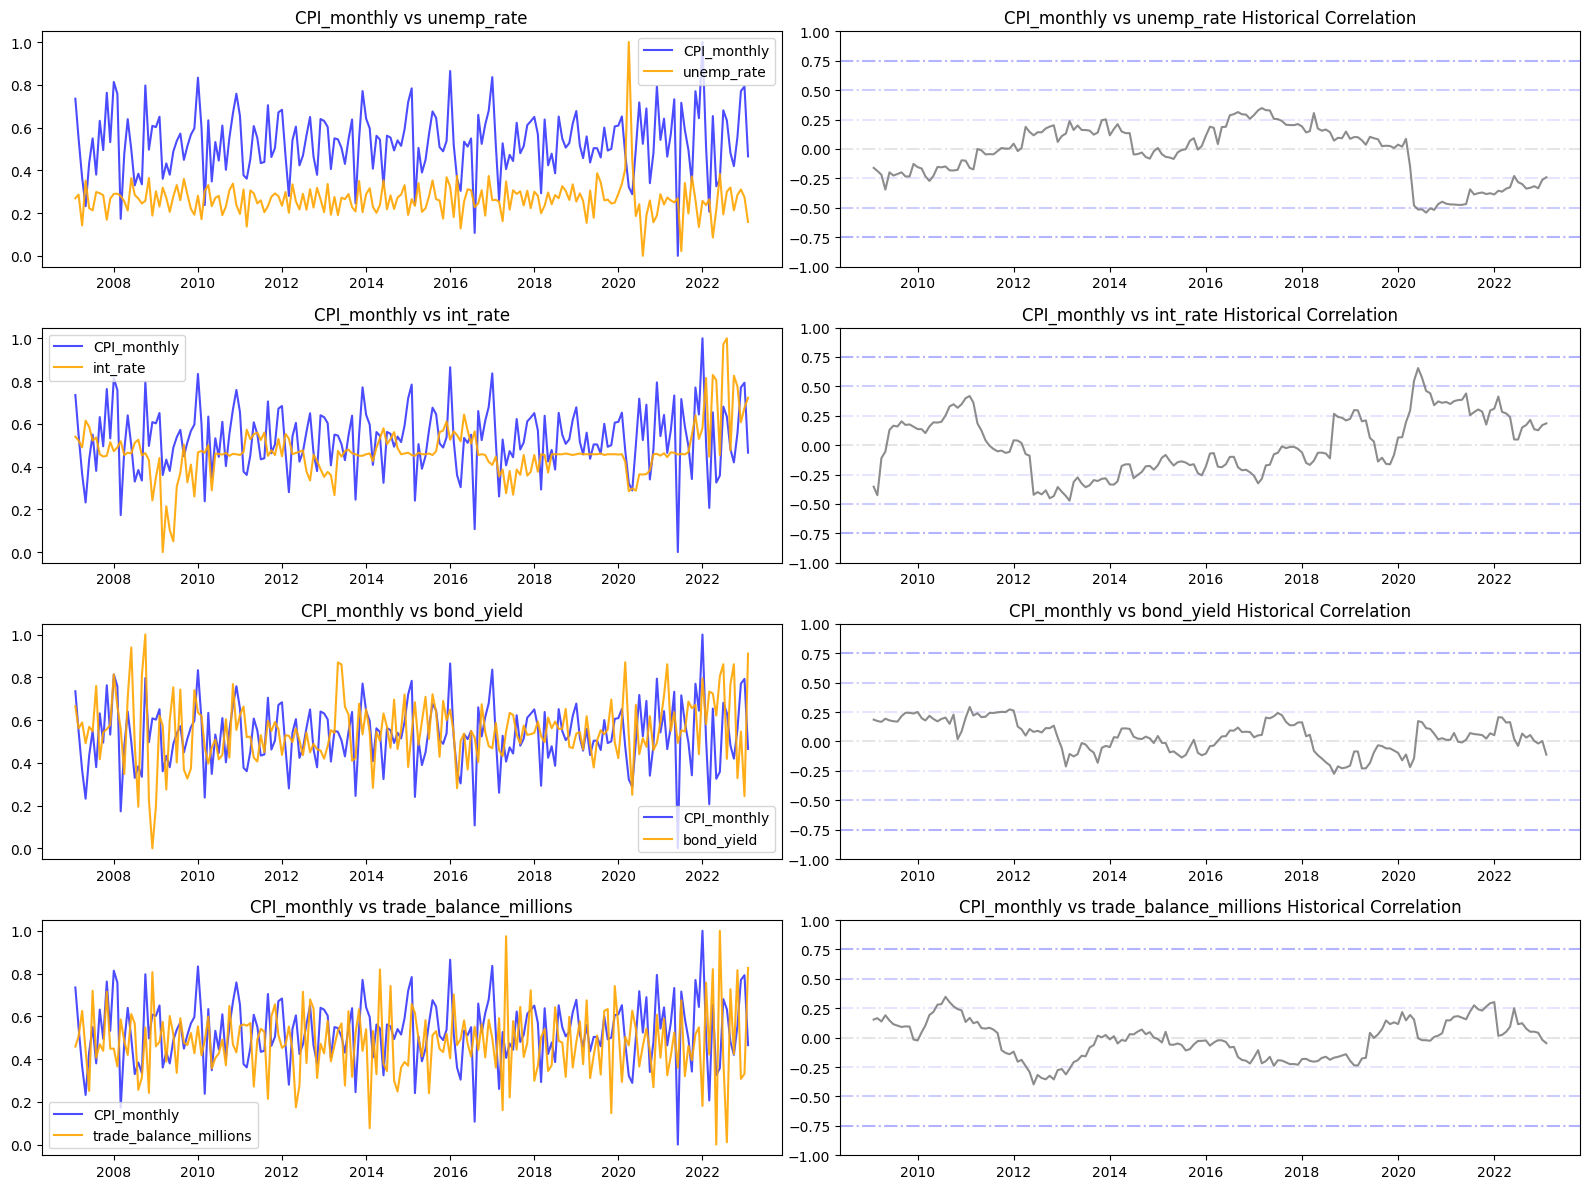

In [ ]:
df_sta_norm = normalize_df(df_sta)

target_var = 'CPI_monthly'
exog_var = df_sta_norm.columns.drop(target_var).values

plot_target_vs_exog(df_sta_norm, target_var, exog_var, plot_corr=True, corr_window=24)

What we see now is the correlation between variances in the explanatory variables and variance in the target variable.

* CPI vs Unemployment rate: ...
* CPI vs interest rates:...
* CPI vs bond yields:...
* CPI vs trade balance:...

There also seem to be 3 diferent perods where the relationship between CPI and each variable seems to behave a little differently. Although not exactly, they seem to be somewhere between 2008-2011, 2011-2019, and 2019-2022. Therefore, it might be useful to try some

### **4.3 Analysis of Seasonality**

Now that we have the series we will work with, it would be useful to identify seasonal patterns that could help us build the forecast models.

For this, we will use the seasonal_decompose function from the Statsmodels library, which follows the theory that a series can be explained as the aggregation of 3 components, trend, seasonality, and errors. This aggregation can be either additive or multiplicative, depending on the nature of the series. Mathematically these two models can be represented as:
* Additive model: Y[t] = T[t] + S[t] + e[t]
* Multiplicative model: Y[t] = T[t] * S[t] * e[t]

Where t indicates a specific time-period; Y represents the value of the series at the specified time period; T means trend; S means seasonality; and e means errors.

Check the [Statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) for more details about this function.

The way we will use the Statsmodels seasonal_decompose function is in a technique that will help us identify the number of time steps within a seasonal period, which we will set for the seasonal component of the forecast models.

The seasonal_decompose function takes a time_series and some arguments to tune the model of seasonal decomposition. The argument we want to experiment with is the "period"; in this argument we set the number of the periods within a season, and the function will calculate means on periods of the specified length after demeaning. This means that we need to know what the number of time steps in a season is, to see its decomposition.

With macroeconomic data, we can expect some it follows yearly patterns, but we cannot be totally sure. Therefore, to identify seasonaity when we are not sure about it, we will perform a technique that consists on iterating over a range of season lengths and capture some metrics that we wil plot to guide us on identifying of those lengths, which one captures the seasonal patterns of the data.

The metrics we will capture are amplitude and residuals, which are defined as:

* Amplitude: difference between the maximum and minimum values of the seasonal series. Higher amplitudes would suggest that a larger range of values can be fit in the seasona component, so that less is captured as a residuals. This is not a perfect measure, as sometimes there might be high amplitude captured by the seasonal component for random reasons, such as if most values of the seasonal component fall on a short range, but one of the values is high, however analyzing it along with the residuals and visual observation of patterns could lead us to a fair decission.

* Residuals: this is what's left of the data after substracting the trend and the seasonal component. It basically represents what cannot be captured by those other components. Ideally, we want to find a season length that along with a high amplitude results in lower residuals compared to season lengths.

In [ ]:
def find_seasonality(series, min_freq=6, max_freq=36, model="additive", extrapolate_trend="freq"):
  amplitudes = []
  RMSEs = []
  series_index = np.arange(min_freq, max_freq+1)

  for i in range(min_freq, max_freq+1):                                         # we apply the following decomposition over the range of lengths within min_freq and max_freq
    decomposition = seasonal_decompose(x=series, model=model, period = i, extrapolate_trend='freq')
    seasonals = decomposition.seasonal                                          # We extract the values of the seasonal component
    residuals = decomposition.resid                                             # We extract the values of the residual component

    # With the seasonal component, we calculate the amplitude of each iteration.
    amplitudes.append(np.max(seasonals) - np.min(seasonals))                    # Amplitude is just the range of values that a series covers. We calculates as the difference between the maximum value and the minimum value

    # With the residual component, we calculate the root mean squared error of each iteration.
    SSR = np.sum(residuals**2)                                                  # Sum of Squared Residuals
    MSE = np.mean(SSR)                                                          # Mean Squared Error
    RMSE = np.sqrt(MSE)                                                         # Root Mean Squared Error
    RMSEs.append(RMSE)

  fig, axes = plt.subplots(1, 2, figsize = (12, 3))

  axes[0].plot(series_index, amplitudes, color='blue', alpha=0.6)
  axes[0].set_title(f'Amplitude of seasonal component for each iteration - {series.name}')
  axes[0].grid(linestyle='-', color='grey', alpha=0.7)
  axes[0].set_xlabel('Period size')
  axes[0].set_ylabel('Amplitude')

  axes[1].plot(series_index, RMSEs, color='blue', alpha=0.6,)
  axes[1].set_title(f'RMSE\'s of seasonal component for each iteration - {series.name}')
  axes[1].grid(linestyle='-', color='grey', alpha=0.7)
  axes[1].set_xlabel('Period size')
  axes[1].set_ylabel('RMSE')

  plt.tight_layout()
  plt.show()

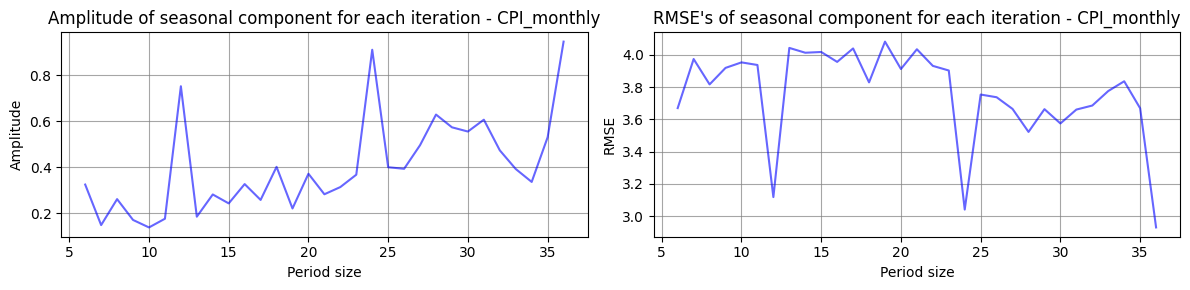

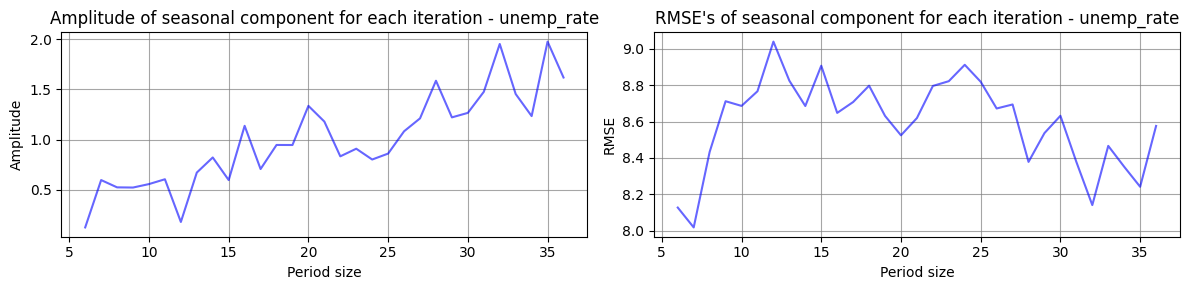

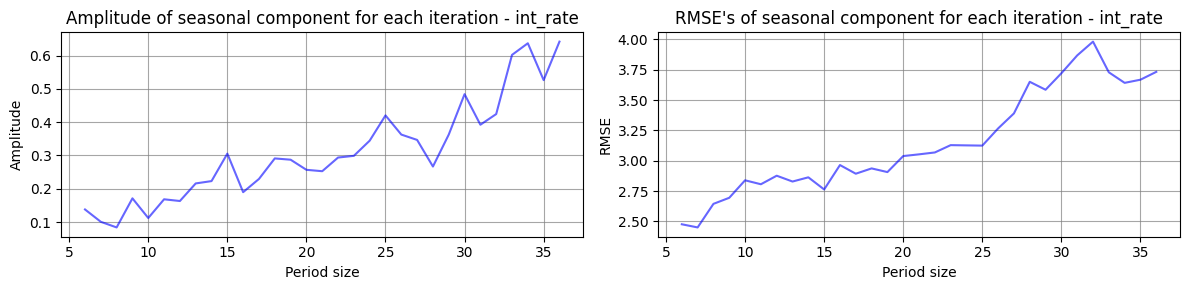

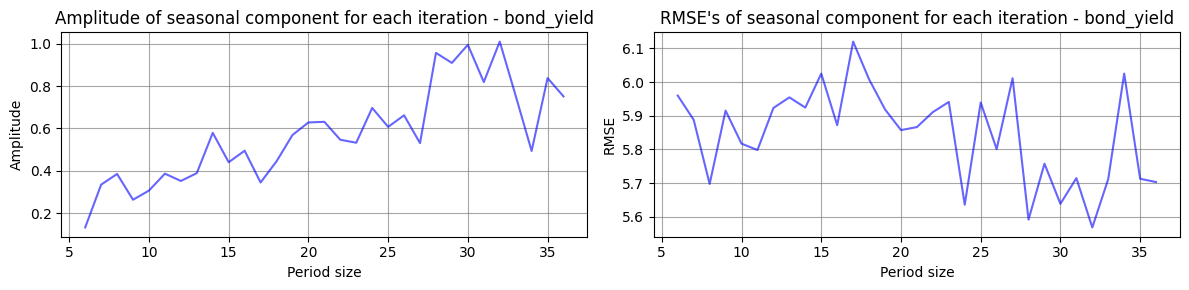

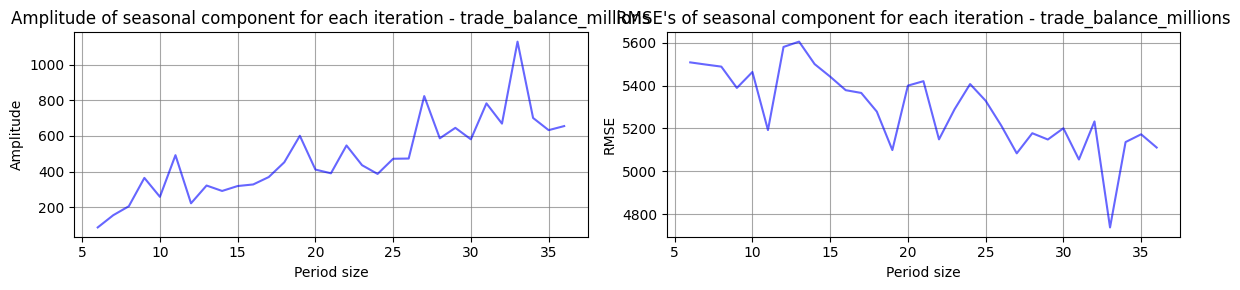

In [ ]:
for var in df_sta.columns:
  find_seasonality(df_sta[var])

As expected, for **CPI**, we see that at length **12**, there is clearly a jump in the amplitud and a fall in the RMSE, suggesting that seasonal patterns develop in that range. We see that for each 12 steps in length (24, 36), the amplitude increases and the error decreases, but this doesn't mean that the seasonal patterns should be higher. The reason why the scores improve each 12 steps, is because the underlying pattern is in a range of 12 time steps, so trying ranges of 24 or 36 will be like capturing the real pattern multiple times, giving it chances of capturing more data the more times the pattern repeats.

For the other series, it's not clear whether there is a seasonal pattern, as the spikes seem to be more random and it's not clear if the amplitude and residuals move together.

For the **trade balance**, there seems to be something like a pattern for each **11** time steps (11, 22, 33). The amplitude at those points spikes and the errors also hit local lows, therefore it might be interesint trying seasonal ranges of 11 time steps for this variable.

For **unemployment rate** and **10-year bond yields** we could try season-lengths of 20 months and 8 months respectively. Although the patterns seem weak, there might be something in those periods.

### **4.4 Correlation between CPI and lags of other variables**



As with a time series itself, we aim to forecast future values based on its previous values. When we include other time series as explanatory variables, sometimes the way these explain the target variable is not through the changes that occurred in the same period, but instead, the target variable in a certain period responds to changes of the explanatory variables that occurred in previous periods.

With this in mind, we also are interested knowing how CPI is correlated with previous observartions of the other variables (what we will refer to as lags).

The following function takes a dataframe and for each of the explanatory variables, calculates the correlation between its lags and the regular CPI series.

In [ ]:
def calculate_lag_correlations(df, target_var, n_lags=20, plot_corr=False):
  corrs = pd.DataFrame(columns=df.columns.values, index=range(n_lags))          # Initialize an empty dataframe with columns for each variable and a row for each number of lags where the function will store the correlations
  std_errors = pd.DataFrame(columns=df.columns.values, index=range(n_lags))     # Initialize an empty dataframe with columns for each variable and a row for each number of lags where the function will store the standaard errors

  if plot_corr not in [True, False]:                                            # Check if the value set in plot_corr is valid (True or False)
    raise ValueError(f"'{plot_corr}' is not a valid value for the plot_corr argument. Valid values are True or False.")

  for var in corrs.columns:                                                     # Iterate over each variable in the dataframe to perform the following calculations
      correlations = []                                                         # Create an empty list where the correlations for each lag will be stored
      std_errors_list = []                                                      # Create an empty list where the standard errors of the correlations will be stored
      for i in range(n_lags):                                                   # Iterate for each number of lags to perform the following calculations
          corr_value = np.corrcoef(df[target_var].values[i:],                   # Call the series of the target variable since position i, to match the length of the lagged series of the explanatory variable
                                   df[var].shift(i).values[i:]                  # Call the lagged series of the explanatory variable
                                   )[0, 1]                                      # Get the correlation between the target variable and the each lag of the explanatory variablle evaluated
          correlations.append(corr_value)                                       # Add the correlation value to the correlations list
          std_err = np.sqrt((1 - corr_value**2)/(len(df.iloc[i:]) - 2))         # Calculate an approximation of the standard error of the correlation
          std_errors_list.append(std_err)
      corrs[var] = correlations                                                 # Add the list of correlations to the corresponding column in the correaations database
      std_errors[var] = std_errors_list

  # Plot the correlations if the argument plot_corr is set to True
  if plot_corr == True:
    nplots = len(corrs.columns)

    fig, axes = plt.subplots(nplots, 1, figsize=(9, 2.5*nplots))
    for i in range(len(corrs.columns)):
      axes[i].stem(corrs[corrs.columns[i]])
      axes[i].set_title("Correlation of {} with lags of {}".format(corrs.columns[0], corrs.columns[i]))
      axes[i].fill_between(
          x=std_errors.index,
          y1=-std_errors[std_errors.columns[i]]*1.96,
          y2=0, color='grey', alpha=0.3
          )                                                                     # Fill the negative side of the 95% confidence interval
      axes[i].fill_between(
          x=std_errors.index,
          y1=std_errors[std_errors.columns[i]]*1.96,
          y2=0, color='grey', alpha=0.3
          )                                                                     # Fill the positive side of the 95% confidence interval
      axes[i].set_xlabel('Lags')

    plt.tight_layout()
    plt.show()

  return corrs

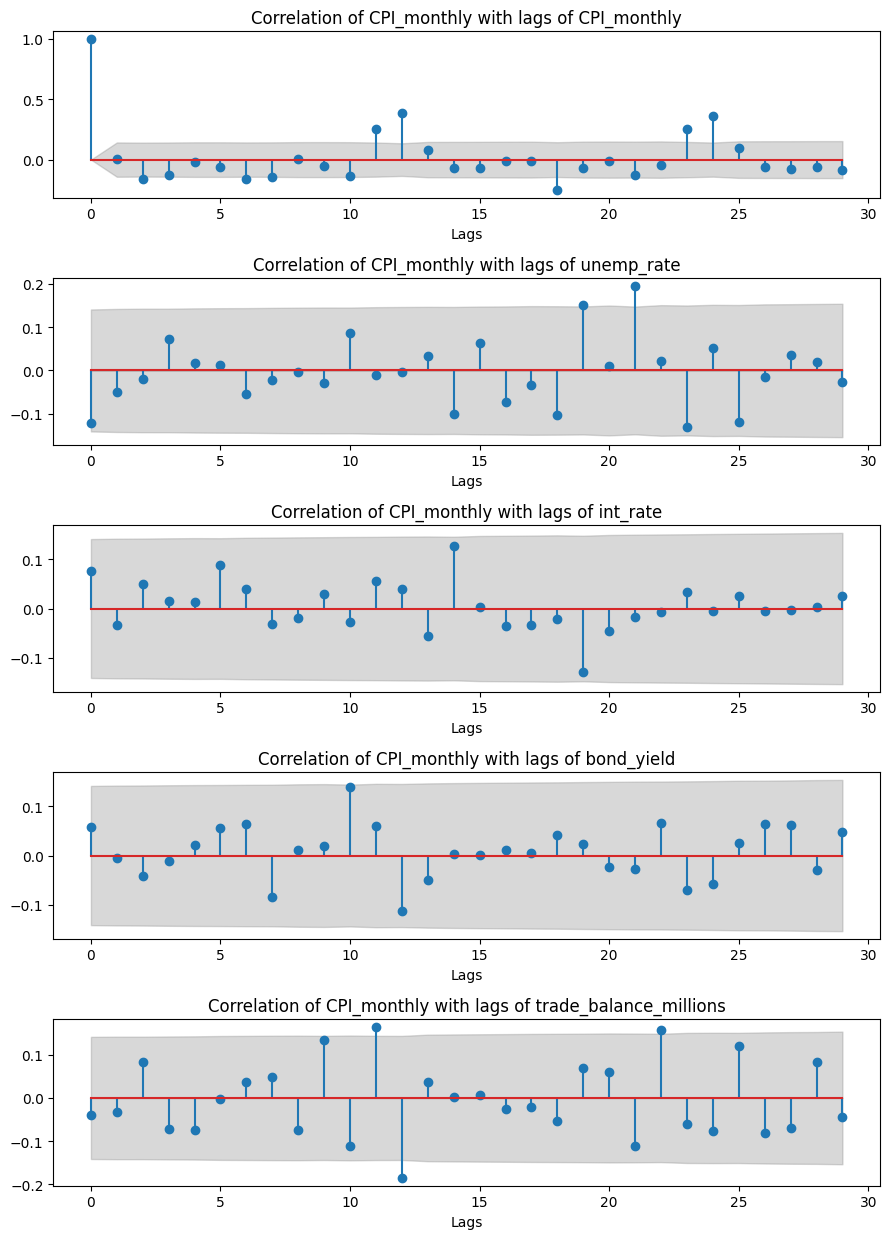

In [ ]:
correlations = calculate_lag_correlations(df_sta, 'CPI_monthly', n_lags=30, plot_corr=True)

Considering the correlations and the 95% confidence interval, we see some correlations of CPI with lags of itself and other variables:

* CPI lags: there is correlation between CPI and its 2nd, 3rd, 6th and 7th lags, as well as the seasonal pattern in the 11th and 12th lags.
* Unemployment rate lags: there's correlation with the inmediate change in unemployment rate. And the only other correlations are with lags far back, such as 19th and 21st.
* Interest rate lags: there doesn't seem to be significant correlation with any of the lags.
* 10-year bond yield lags: there doesn't seem to be significaant correlation with any of the lags.
* Trade balance: we see significant correlation with lags 11th and 12th.

### **4.5 Partial Correlation between CPI and lags of other variables**

Similar to how we calculated the correlation of CPI with lags of the other variables, we may want to calculate the partial correlation of CPI with lags of the other variables, which is essentially the correlation but removing the effect of previous lags. The method we will use for this will be performing OLS regressions of CPI vs all lags until lag *t* of variable *x* to get the partial autocorrelation of lag *t*.

In [ ]:
def calculate_lag_partial_correlations(df, target_var, n_lags=20, plot_corr=False):

  corrs = pd.DataFrame(columns=df.columns.values, index=range(n_lags))          # Initialize an empty dataframe with columns for each variable and a row for each number of lags where the function will store the correlations
  std_errors = pd.DataFrame(columns=df.columns.values, index=range(n_lags))     # Initialize an empty dataframe with columns for each variable and a row for each number of lags where the function will store the standaard errors

  if plot_corr not in [True, False]:                                            # Check if the value set in plot_corr is valid (True or False)
    raise ValueError(f"'{plot_corr}' is not a valid value for the plot_corr argument. Valid values are True or False.")

  for var in corrs.columns:
    partial_correlations = []
    std_errors_list = []
    var_lags_df = pd.DataFrame(lagmat(df[var], n_lags, original='in'),
                               index=df.index)
    for i in range(n_lags):
      if var == target_var and i != 0:
        linear_mod = sm.OLS(df[target_var][i:],
                    sm.add_constant(var_lags_df.iloc[i:, 1:i+1])).fit()
      else:
        linear_mod = sm.OLS(df[target_var][i:],
                            sm.add_constant(var_lags_df.iloc[i:, :i+1])).fit()
      partial_correlations.append(list(linear_mod.params)[-1])
      std_errors_list.append(list(linear_mod.bse)[-1])
    corrs[var] = partial_correlations
    std_errors[var] = std_errors_list


  # Plot the correlations if the argument plot_corr is set to True
  if plot_corr == True:
    nplots = len(corrs.columns)

    fig, axes = plt.subplots(nplots, 1, figsize=(9, 2.5*nplots))
    for i in range(len(corrs.columns)):
      axes[i].stem(corrs[corrs.columns[i]])
      axes[i].set_title("Correlation of {} with lags of {}".format(corrs.columns[0], corrs.columns[i]))
      axes[i].fill_between(
          x=std_errors.index,
          y1=-std_errors[std_errors.columns[i]]*1.96,
          y2=0, color='grey', alpha=0.3
          )                                                                     # Fill the negative side of the 95% confidence interval
      axes[i].fill_between(
          x=std_errors.index,
          y1=std_errors[std_errors.columns[i]]*1.96,
          y2=0, color='grey', alpha=0.3
          )                                                                     # Fill the positive side of the 95% confidence interval
      axes[i].set_xlabel('Lags')

    plt.tight_layout()
    plt.show()

  return corrs

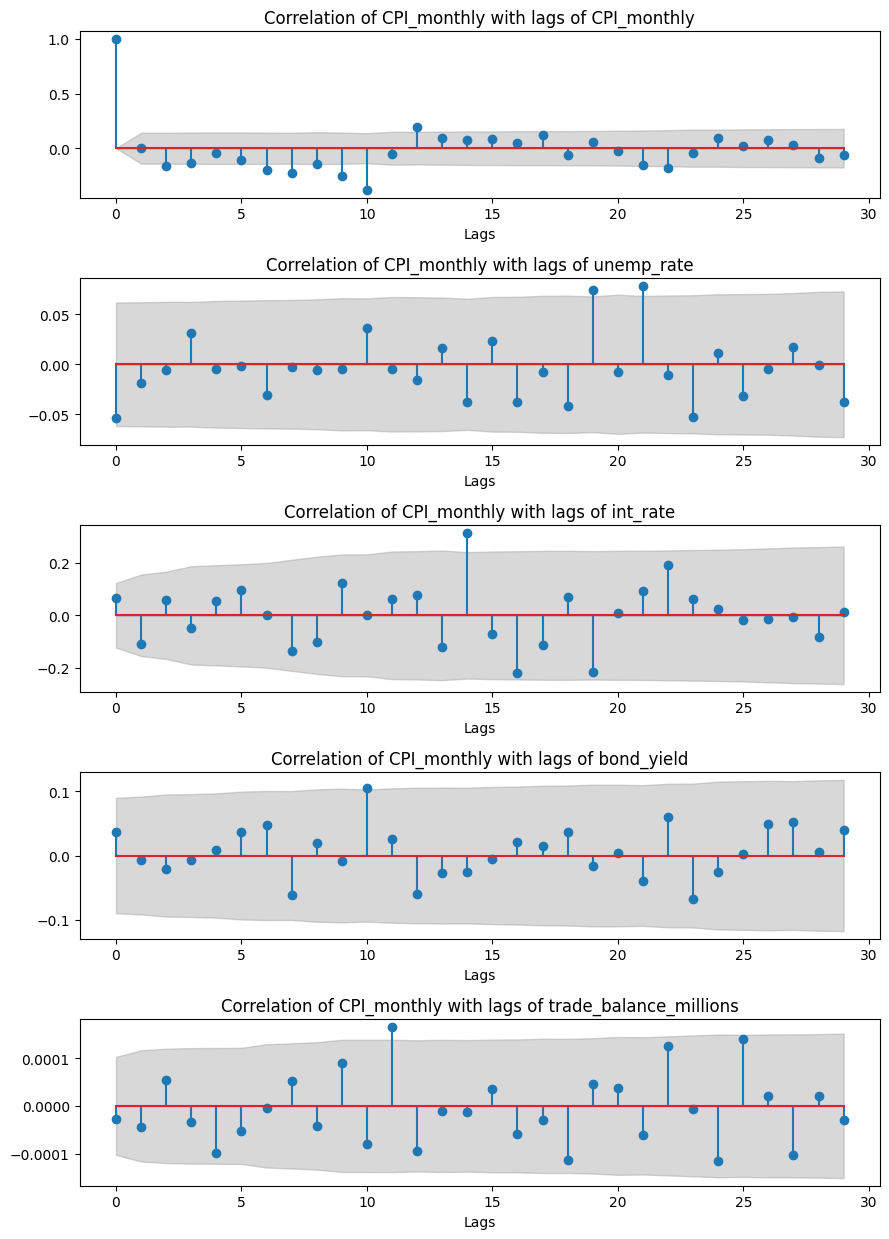

In [ ]:
correlations = calculate_lag_partial_correlations(df_sta, 'CPI_monthly', n_lags=30, plot_corr=True)

## **5. Modeling Colombia's CPI**




### **5.1 Putting all together**

Taking the insights from the previous analysis, we can start testing some assumptions, especially regarding the exogenous variables and how they are related to the CPI.

* First, we will check how the lags suggested by the analysis of the partial correlations are useful in explaining the changes in the CPI.
* Second, we will check wheter it's useful to specify in the model that the behaviors between the variables unemployment raate and interest rate have been different during the periods 2008 to 2011, from 2011 to 2019, and from 2019 onwards.
* Third, we will check how the seasonal component suggested by the analysis of amplitude and RMSE for mutiple season lengths contributes to the prediction of CPI.

### **5.1.1 Determining lags of exogenous variables***

According to the partial correlation analysis, the following lags of the explanatory variables are significant even when taking into account the potential effects of all their previous lags:
* Unemployment rate: lags 19 and 21.
* Interest rates: lag 14.
* Bond yields: lag 10.
* Trade baance: lag 11.

Therefore, the next step is to create new variables for these lags and perform regressions to evaluate their significance as predictors.

In [ ]:
model_df = df_sta.copy()

model_df['unemp_rate_L19'] = model_df['unemp_rate'].shift(19)
model_df['unemp_rate_L21'] = model_df['unemp_rate'].shift(21)
model_df['int_rate_L14'] = model_df['int_rate'].shift(14)
model_df['bond_yield_L10'] = model_df['bond_yield'].shift(10)
model_df['trade_balance_L11'] = model_df['trade_balance_millions'].shift(11)

For the regressions, we use the [Statsmodels formula](https://www.statsmodels.org/devel/example_formulas.html) module, which makes it easier to write regression equations by receiving R-styled formulas as inputs.

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.166
Date:                Tue, 23 May 2023   Prob (F-statistic):           0.000197
Time:                        15:03:46   Log-Likelihood:                -14.477
No. Observations:                 172   AIC:                             40.95
Df Residuals:                     166   BIC:                             59.84
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0150      0.021      0.724      0.470      -0.026       0.056
unemp_rate_L19        0.0724      0.030      2.377      0.019       0.012       0.133
unemp_rate_L21        0.0761      0.031      2.441      0.016       0.015       0.138
int_rate_L14          0.1903      0.082      2.317      0.022       0.028       0.353
bond_yield_L10        0.0784      0.046      1.712      0.089      -0.012       0.169
trade_balance_L11     0.0001   5.71e-05      2.446      0.015    2.69e-05       0.000
==============================================================================
Omnibus:                        4.286   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                3.993
Skew:                          -0.272   Prob(JB):                        0.136
Kurtosis:                       3.511   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For 4 of the lags tested of the exogenous variables, the coefficients are significantly different from 0 under a 5% confidence threshold. Only the 10th lag of bond yields show a p-value higher than .05 but is still significantly different from 0 under a 10% confidence threshold.

Additionally, the model residuals seem to be close to a normal distribution with a Jarque Bera and Omnibus normality tests' probability values higher than the .1 of our confidence threshold. The Durbin-Watson score close to 2 also suggest there might not be serious autocorrelation of the residuals.

Thes results suggest the model with these lags of the exogenous variable is well specfied, so we will keep the variables.

### **5.1.2 Testing structural breaks**

....


In [ ]:
model_df['temp_date'] = model_df.index                                          # We extract the date index as a column so that we can generate a

# Now we create the 3 dummies by extracting the year of the date and setting a condition based on the year:
# Before 2012; between 2012 and 2020; all before 2020
model_df['before_2012'] = model_df['temp_date'].apply(lambda x: 1 if int(str(x).split('-')[0]) < 2012 else 0)
model_df['2012_to_2020'] = model_df['temp_date'].apply(lambda x: 1 if int(str(x).split('-')[0]) >= 2012 and int(str(x).split('-')[0]) < 2020 else 0)
model_df['before_2020'] = model_df['temp_date'].apply(lambda x: 1 if int(str(x).split('-')[0]) < 2020 else 0)

model_df.drop(columns='temp_date', inplace=True)                                # We drop the temp_date column that is no longer needed

# Interations for the variables and the date before 2012 dummy
model_df['unemp_rate_L19_before_2012'] = model_df['unemp_rate_L19']*model_df['before_2012']
model_df['unemp_rate_L21_before_2012'] = model_df['unemp_rate_L21']*model_df['before_2012']
model_df['int_rate_L14_before_2012'] = model_df['int_rate_L14']*model_df['before_2012']
model_df['bond_yield_L10_before_2012'] = model_df['bond_yield_L10']*model_df['before_2012']
model_df['trade_balance_L11_before_2012'] = model_df['trade_balance_L11']*model_df['before_2012']

# Interactions for the variables and the date between 2012 nd 2020 dummy
model_df['unemp_rate_L19_between_2012_2020'] = model_df['unemp_rate_L19']*model_df['2012_to_2020']
model_df['unemp_rate_L21_between_2012_2020'] = model_df['unemp_rate_L21']*model_df['2012_to_2020']
model_df['int_rate_L14_between_2012_2020'] = model_df['int_rate_L14']*model_df['2012_to_2020']
model_df['bond_yield_L10_between_2012_2020'] = model_df['bond_yield_L10']*model_df['2012_to_2020']
model_df['trade_balance_L11_between_2012_2020'] = model_df['trade_balance_L11']*model_df['2012_to_2020']

# Interactions for the variables and the date before 2020 dummy
model_df['unemp_rate_L19_before_2020'] = model_df['unemp_rate_L19']*model_df['before_2020']
model_df['unemp_rate_L21_before_2020'] = model_df['unemp_rate_L21']*model_df['before_2020']
model_df['int_rate_L14_before_2020'] = model_df['int_rate_L14']*model_df['before_2020']
model_df['bond_yield_L10_before_2020'] = model_df['bond_yield_L10']*model_df['before_2020']
model_df['trade_balance_L11_before_2020'] = model_df['trade_balance_L11']*model_df['before_2020']

In [ ]:
# We test a model with the lagged exogenous variables and the interacton of those lags and the "before 2012" and "between 2012 and 2020 dummies"
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + unemp_rate_L19_before_2012 + unemp_rate_L21_before_2012 + int_rate_L14_before_2012 + bond_yield_L10_before_2012 + trade_balance_L11_before_2012'+
                     ' + unemp_rate_L19_between_2012_2020 + unemp_rate_L21_between_2012_2020 + int_rate_L14_between_2012_2020 + bond_yield_L10_between_2012_2020 + trade_balance_L11_between_2012_2020', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     3.002
Date:                Tue, 23 May 2023   Prob (F-statistic):           0.000303
Time:                        15:32:08   Log-Likelihood:                -5.1059
No. Observations:                 172   AIC:                             42.21
Df Residuals:                     156   BIC:                             92.57
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0060      0.021      0.287      0.774      -0.035       0.047
unemp_rate_L19                          0.1046      0.038      2.721      0.007       0.029       0.181
unemp_rate_L21                          0.1210      0.040      3.013      0.003       0.042       0.200
int_rate_L14                            0.5605      0.251      2.233      0.027       0.065       1.056
bond_yield_L10                          0.2244      0.109      2.056      0.041       0.009       0.440
trade_balance_L11                       0.0002      0.000      1.428      0.155   -6.41e-05       0.000
unemp_rate_L19_before_2012             -0.1070      0.109     -0.986      0.326      -0.321       0.107
unemp_rate_L21_before_2012             -0.1091      0.109     -1.000      0.319      -0.324       0.106
int_rate_L14_before_2012               -0.4682      0.272     -1.719      0.088      -1.006       0.070
bond_yield_L10_before_2012             -0.1708      0.128     -1.337      0.183      -0.423       0.081
trade_balance_L11_before_2012       -4.243e-05      0.000     -0.211      0.833      -0.000       0.000
unemp_rate_L19_between_2012_2020       -0.0346      0.073     -0.472      0.638      -0.179       0.110
unemp_rate_L21_between_2012_2020       -0.2072      0.074     -2.810      0.006      -0.353      -0.062
int_rate_L14_between_2012_2020         -0.4129      0.287     -1.437      0.153      -0.981       0.155
bond_yield_L10_between_2012_2020       -0.2619      0.140     -1.872      0.063      -0.538       0.014
trade_balance_L11_between_2012_2020 -6.297e-05      0.000     -0.459      0.647      -0.000       0.000
==============================================================================
Omnibus:                        3.072   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.925
Skew:                          -0.157   Prob(JB):                        0.232
Kurtosis:                       3.556   Cond. No.                     9.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Many of the interactons are not sgnificant predictors judging by their p-values. We should then clean up some of them and leave only the relevant ones.

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + int_rate_L14_before_2012'+
                     ' + unemp_rate_L21_between_2012_2020 + int_rate_L14_between_2012_2020 + bond_yield_L10_between_2012_2020', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     4.613
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.94e-05
Time:                        15:33:21   Log-Likelihood:                -7.2910
No. Observations:                 172   AIC:                             34.58
Df Residuals:                     162   BIC:                             66.06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0092      0.020      0.448      0.655      -0.031       0.050
unemp_rate_L19                       0.0850      0.031      2.784      0.006       0.025       0.145
unemp_rate_L21                       0.1252      0.035      3.573      0.000       0.056       0.194
int_rate_L14                         0.5798      0.240      2.415      0.017       0.106       1.054
bond_yield_L10                       0.1092      0.054      2.034      0.044       0.003       0.215
trade_balance_L11                    0.0001   5.61e-05      2.358      0.020    2.15e-05       0.000
int_rate_L14_before_2012            -0.4920      0.261     -1.888      0.061      -1.007       0.023
unemp_rate_L21_between_2012_2020    -0.2108      0.071     -2.978      0.003      -0.351      -0.071
int_rate_L14_between_2012_2020      -0.4371      0.277     -1.578      0.117      -0.984       0.110
bond_yield_L10_between_2012_2020    -0.1513      0.102     -1.483      0.140      -0.353       0.050
==============================================================================
Omnibus:                        4.070   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.733
Skew:                          -0.267   Prob(JB):                        0.155
Kurtosis:                       3.485   Cond. No.                     7.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's compare this model with a models using only the "before 2020" dummy.

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + unemp_rate_L21_before_2020 + int_rate_L14_before_2020 + bond_yield_L10_before_2020 + trade_balance_L11_before_2020', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     4.815
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.06e-05
Time:                        16:10:36   Log-Likelihood:                -6.5296
No. Observations:                 172   AIC:                             33.06
Df Residuals:                     162   BIC:                             64.53
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0084      0.020      0.416      0.678      -0.032       0.048
unemp_rate_L19                    0.0842      0.031      2.741      0.007       0.024       0.145
unemp_rate_L21                    0.1228      0.040      3.094      0.002       0.044       0.201
int_rate_L14                      0.5231      0.245      2.140      0.034       0.040       1.006
bond_yield_L10                    0.2170      0.108      2.015      0.046       0.004       0.430
trade_balance_L11                 0.0002      0.000      1.495      0.137   -5.55e-05       0.000
unemp_rate_L21_before_2020       -0.1813      0.066     -2.768      0.006      -0.311      -0.052
int_rate_L14_before_2020         -0.3942      0.257     -1.533      0.127      -0.902       0.114
bond_yield_L10_before_2020       -0.2085      0.119     -1.749      0.082      -0.444       0.027
trade_balance_L11_before_2020 -5.778e-05      0.000     -0.437      0.663      -0.000       0.000
==============================================================================
Omnibus:                        2.074   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                1.707
Skew:                          -0.135   Prob(JB):                        0.426
Kurtosis:                       3.407   Cond. No.                     8.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the score, a model just distinguishing before 2020 should perform better, but we have some interaction terms that are not significant, which we may want to remove.

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + unemp_rate_L21_before_2020 + bond_yield_L10_before_2020', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     5.765
Date:                Tue, 23 May 2023   Prob (F-statistic):           5.55e-06
Time:                        16:06:07   Log-Likelihood:                -7.9952
No. Observations:                 172   AIC:                             31.99
Df Residuals:                     164   BIC:                             57.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0060      0.020      0.299      0.766      -0.034       0.046
unemp_rate_L19                 0.0747      0.030      2.504      0.013       0.016       0.134
unemp_rate_L21                 0.1205      0.039      3.064      0.003       0.043       0.198
int_rate_L14                   0.1713      0.080      2.146      0.033       0.014       0.329
bond_yield_L10                 0.2448      0.106      2.299      0.023       0.035       0.455
trade_balance_L11              0.0001   5.54e-05      2.397      0.018    2.34e-05       0.000
unemp_rate_L21_before_2020    -0.1782      0.065     -2.727      0.007      -0.307      -0.049
bond_yield_L10_before_2020    -0.2360      0.118     -1.999      0.047      -0.469      -0.003
==============================================================================
Omnibus:                        5.529   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.753
Skew:                          -0.284   Prob(JB):                       0.0563
Kurtosis:                       3.692   Cond. No.                     2.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A model with the lags of the exogenous variables and the interaction terms for the 21st lag of unemployment rate before 2020 and the 10th lag of the 10-year bond yields before 2020 give better results, judging by the significance of the predictors and scores such as the AIC and the BIC.

### **5.1.3 Adding seasonality**

For last, we check the significance of the seasonal component on predicting Colombia's CPI.

As we concluded in the analysis of seasonal components, 12 periods or periods mutiples of 12 seem to be the most accurate season-length to describe the seasonalty of CPI, so we will add it to the model and see how it performs.

We will test with lags of up to 48 periods, to check whether the seasonality should consider even more lags than the 12th period behind.

In [ ]:
# We creat
model_df['CPI_monthly_L12'] = model_df['CPI_monthly'].shift(12)
model_df['CPI_monthly_L24'] = model_df['CPI_monthly'].shift(24)
model_df['CPI_monthly_L36'] = model_df['CPI_monthly'].shift(36)
model_df['CPI_monthly_L48'] = model_df['CPI_monthly'].shift(48)

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + unemp_rate_L21_before_2020 + bond_yield_L10_before_2020'+
                     ' + CPI_monthly_L12 + CPI_monthly_L24 + CPI_monthly_L36 + CPI_monthly_L48', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     8.751
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.52e-11
Time:                        17:48:25   Log-Likelihood:                 14.350
No. Observations:                 145   AIC:                            -4.699
Df Residuals:                     133   BIC:                             31.02
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0015      0.019      0.078      0.938      -0.037       0.040
unemp_rate_L19                 0.0666      0.027      2.435      0.016       0.013       0.121
unemp_rate_L21                 0.1264      0.035      3.608      0.000       0.057       0.196
int_rate_L14                   0.2868      0.100      2.867      0.005       0.089       0.485
bond_yield_L10                 0.0750      0.098      0.768      0.444      -0.118       0.268
trade_balance_L11              0.0001   5.33e-05      2.217      0.028    1.28e-05       0.000
unemp_rate_L21_before_2020    -0.1728      0.063     -2.757      0.007      -0.297      -0.049
bond_yield_L10_before_2020     0.0135      0.124      0.109      0.913      -0.232       0.259
CPI_monthly_L12                0.2578      0.077      3.339      0.001       0.105       0.410
CPI_monthly_L24                0.1111      0.092      1.205      0.230      -0.071       0.293
CPI_monthly_L36                0.1456      0.087      1.681      0.095      -0.026       0.317
CPI_monthly_L48                0.1319      0.081      1.634      0.105      -0.028       0.292
==============================================================================
Omnibus:                       17.103   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.888
Skew:                          -0.560   Prob(JB):                     3.23e-07
Kurtosis:                       4.922   Cond. No.                     2.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Initially, having up to the 48 lag, some lags are not significant. Moreover, once we account for the effect of the lags, the effect from the yield of the 10-year bonds becomes insignificant. We should then remove some of the lags and review the effect of the bond yields.

In [ ]:
linear_mod = smf.ols('CPI_monthly ~ unemp_rate_L19 + unemp_rate_L21 + int_rate_L14 + bond_yield_L10 + trade_balance_L11'+
                     ' + unemp_rate_L21_before_2020'+
                     ' + CPI_monthly_L12 + CPI_monthly_L24', model_df).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CPI_monthly   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     12.80
Date:                Tue, 23 May 2023   Prob (F-statistic):           3.76e-14
Time:                        20:04:54   Log-Likelihood:                 14.167
No. Observations:                 169   AIC:                            -10.33
Df Residuals:                     160   BIC:                             17.84
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0077      0.018      0.429      0.669      -0.028       0.043
unemp_rate_L19                 0.0615      0.026      2.335      0.021       0.009       0.114
unemp_rate_L21                 0.1308      0.033      3.915      0.000       0.065       0.197
int_rate_L14                   0.1401      0.070      1.990      0.048       0.001       0.279
bond_yield_L10                 0.0810      0.041      1.992      0.048       0.001       0.161
trade_balance_L11              0.0001   4.91e-05      2.827      0.005    4.18e-05       0.000
unemp_rate_L21_before_2020    -0.1679      0.059     -2.856      0.005      -0.284      -0.052
CPI_monthly_L12                0.3296      0.067      4.956      0.000       0.198       0.461
CPI_monthly_L24                0.2424      0.071      3.414      0.001       0.102       0.383
==============================================================================
Omnibus:                       19.679   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.605
Skew:                          -0.572   Prob(JB):                     1.86e-08
Kurtosis:                       4.936   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After cleaning, the best combination found is when we consider the effect of 2 seasonal periods of 12 months, and remove the effect of the bond yields for periods before 2020.

Interestingly, once we include the the seasonal component, the residuals of the model don't seem to have a normal distribution anymore, and seem biased to the negative side. Some literature suggest that this should not be an issue in most cases with time series models as long as other metrics indicate a well specified model. Regarding the autocorrelation of the residuals, judging by the Dubrin-Watson score thata remains close to 2, there doesn't seem to be serious autocorrelation.

### **Grid-search for best model tuning**

Now that we identified the exogenous components to include in the model, the next step is to finally employ a grid-search method to determine the best SARIMA paarameters to predict Colombia's CPI.

For this, we can use two functions that together make it possible to test multiple parameter combinations in real predictions and then return some error metrics from all the iterations, so that we can see how each specification performs.

* evaluate_sarimax_model: this function will take a specific SARIMAX specification (target variable, exogenous variables, ARIMA order and seasonal order), separate the data into a training and validation set, and then perform 1 period predictions with the training data, feed the dataset back with the real value for the prediction period, and continue that process until predictions have been performed for each period of the validation set.

* evaluate_sarimax_models: this function will take lists of SARIMAX model specifications and perform the evaluate_sarimax_model over all the possible combinations of specifications while saving the specified error score of each of the models performed to at the end return the 3 best models evaluated.

So first we have to define the functions.

In [ ]:
# evaluate a SARIMA model for a given order (p,d,q) (P, D, Q, S)
def evaluate_sarima_model(X, arima_order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), train_size=0.8, error='RMSE', verbose=False, plot_values=False):
  import warnings
  warnings.filterwarnings('ignore')

  # prepare training dataset
  train_size = int(len(X) * train_size)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

    if verbose==True:
      print(f"Iteration {t+1} completed for model {arima_order}, {seasonal_order}. Prediction: {yhat}, Real value: {test[t]}.")
  # calculate out of sample error
  MSE = np.mean((test - predictions)**2)**(1/2)
  RMSE = np.sqrt(np.mean((test - predictions)**2)**(1/2))
  WAPE = np.sum(np.abs(test - predictions))/np.sum(np.abs(test))

  errors = {'MSE': MSE, 'RMSE': RMSE, 'WAPE': WAPE}
  error_val = errors[error]

  if plot_values==True:
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes.plot(test.index, predictions, color='blue', label='Predictions')
    axes.plot(test.index, test, color='orange', label='Real values')
    axes.set_title(f"Model {arima_order} {seasonal_order} Predictions vs Real Values")
    axes.legend()

  return error_val

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_sarimax_models(series, p_values=[0], d_values=[0], q_values=[0], P_values=[0], D_values=[0], Q_values=[0], S_values=[0], train_size=0.8, error='RMSE'):
  series = series.astype('float32')
  best_score, best_cfg, best_so = float("inf"), None, None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        for P in P_values:
          for D in D_values:
            for Q in Q_values:
              for S in S_values:
                order = (p, d, q)
                seasonal_order = (P, D, Q, S)
                try:
                  error_val = evaluate_sarima_model(series, order, seasonal_order, train_size, error)
                  if error_val < best_score:
                    best_score, best_cfg, best_so = error, order, seasonal_order
                  print('ARIMA%s %s=%.3f' % (order, seasonal_order, error, error_val))
                except:
                  continue
  print('Best ARIMA %s %s %s=%.3f' % (best_cfg, best_so, error, best_score))

Then we need to clean the df for the model to eliminate unnecessary columns but mainly to remove NA values generated when creating the columns with the lags of the exogenous variables.

In [ ]:
model_df = model_df[['CPI_monthly', 'unemp_rate_L19', 'unemp_rate_L21', 'int_rate_L14', 'bond_yield_L10', 'trade_balance_L11', 'unemp_rate_L21_before_2020']]
model_df.dropna(how='any', inplace=True)
model_df.head()

<ipython-input-139-d0eccb13ae0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(how='any', inplace=True)


,CPI_monthly,unemp_rate_L19,unemp_rate_L21,int_rate_L14,bond_yield_L10,trade_balance_L11,unemp_rate_L21_before_2020
DATE,,,,,,,
2008-11-01,-0.061612,-0.996779,0.029208,0.00,0.856957,-79.896590,0.029208
2008-12-01,0.159914,0.693567,0.165220,-0.03,0.376435,-79.303906,0.165220
2009-01-01,0.148055,-0.344159,-0.996779,-0.02,0.037588,-294.990773,-0.996779
2009-02-01,0.245073,-0.426876,0.693567,0.16,-0.638467,272.551371,0.693567
2009-03-01,-0.332263,0.264345,-0.344159,0.04,0.513485,10.894678,-0.344159


In [ ]:
model = ARIMA(model_df['CPI_monthly'], model_df[['unemp_rate_L19', 'unemp_rate_L21', 'int_rate_L14', 'bond_yield_L10', 'trade_balance_L11', 'unemp_rate_L21_before_2020']], order=(2, 0, 1), seasonal_order=(2, 0, 1, 12))

MissingDataError: ignored

In [ ]:
series = df_sta['CPI_monthly']
p_values = [x for x in range(13)]
q_values = [x for x in range(13)]
P_values = [0, 1, 2]
Q_values = [0, 1, 2]
S_values = [0, 12]

Iteration 1 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: 0.19708368041904814, Real value: 0.155103910709475.
Iteration 2 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: 0.3783416629403779, Real value: 0.162097504336556.
Iteration 3 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: 0.1851144440273986, Real value: 0.24751290072662702.
Iteration 4 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: -0.29936380781215977, Real value: -0.10422198839410202.
Iteration 5 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: -0.08319289061943626, Real value: -0.408494404344383.
Iteration 6 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: -0.014115087995041672, Real value: -0.475413156159292.
Iteration 7 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: 0.11439170586241555, Real value: -0.057714124978827996.
Iteration 8 completed for model (2, 0, 2), (1, 0, 1, 12). Prediction: 0.10469213816881269, Real value: 0.3776017004585398.
Iteration 

0.5580459661440138

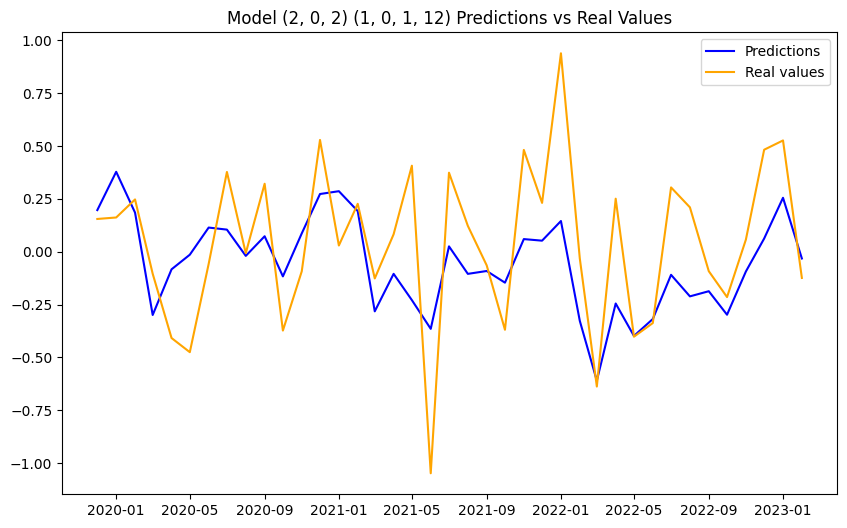

In [ ]:
evaluate_sarima_model(series, arima_order=(2, 0, 2), seasonal_order=(1, 0, 1, 12), train_size=0.8, error='RMSE', verbose=True, plot_values=True)

In [ ]:
evaluate_models(series, p_values=p_values, q_values=q_values, P_values=P_values, Q_values=Q_values, S_values=S_values)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

### **4.6 Autocorrelation and Partial Autocorrelation**

The final piece of this analysis section is getting the atocorrelation function and partial autocorrelation function for the variables of o

### **Correlations Analysis**

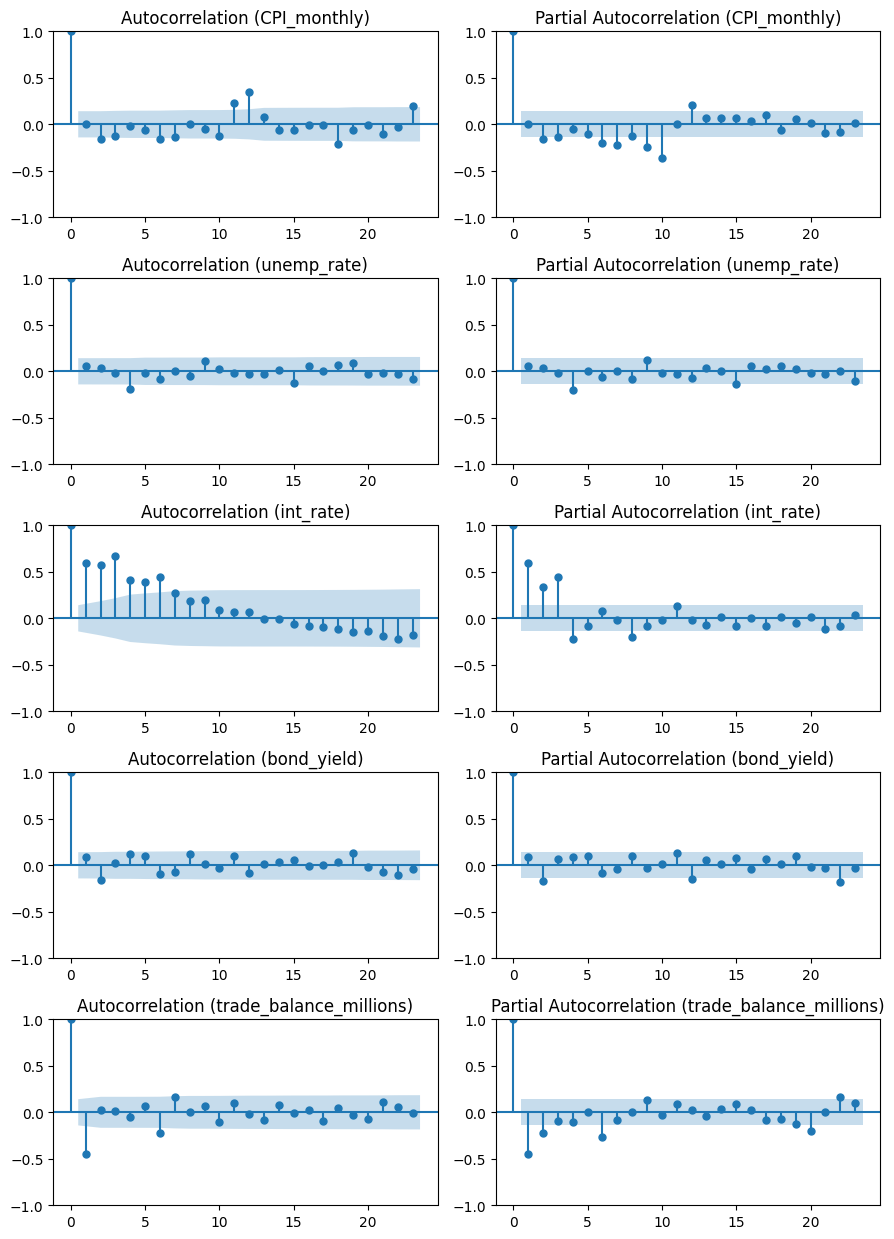

In [ ]:
nplots = len(df_sta.columns)

fig, axes = plt.subplots(nplots, 2, figsize=(9, 2.5*nplots))
for i in range(nplots):
  fig = plot_acf(df_sta[df_sta.columns[i]], ax=axes[i, 0])
  fig = plot_pacf(df_sta[df_sta.columns[i]], ax=axes[i, 1])

  axes[i, 0].set_title("Autocorrelation ({})".format(df_sta.columns[i]))
  axes[i, 1].set_title("Partial Autocorrelation ({})".format(df_sta.columns[i]))

plt.tight_layout()
plt.show()